# Fine-Tuning Vision Transformers for Image Classification through timm

The goal of this notebook is to create an image classifier for sattelite images, using timm (and pytorch) on the EUROSAT dataset.
We will fine-tune a Vision Transformer (ViT), as research shows this is the best appraoch for multi-class classification [1].

Adapted from: https://www.kaggle.com/code/hinepo/transfer-learning-with-timm-models-and-pytorch

# Installs

Preprend ! to run in colab

Might use VSCODE_PID to check for where execution takes place

In [63]:
!pip install timm torchvision albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing

In [64]:
import numpy as np
import matplotlib.pyplot as plt

import time
import random # for torch seed
import os # for torch seed

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

from PIL import Image

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import torchvision

# CFG

This class enables easy configuration to simulate and understand results.

You can tweak some parameters and see how they impact on the metrics, plots, and predictions.

In [65]:
class CFG:
  OUTPUT_PATH = './'

  ### input: not configurable
  IMG_HEIGHT = 28
  IMG_WIDTH = 28

  ### split train and validation sets
  split_fraction = 0.8

  ### model
  model_name = 'resnet50' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...

  ### training
  print_freq = 100
  BATCH_SIZE = 64
  N_EPOCHS = 40

  ### set only one to True
  save_best_loss = False
  save_best_accuracy = True

  ### optimizer
  # optimizer = 'adam'
  # optimizer = 'adamw'
  optimizer = 'rmsprop'
  LEARNING_RATE = 1e-3
  weight_decay = 0.1 # for adamw
  l2_penalty = 0.01 # for RMSprop
  rms_momentum = 0 # for RMSprop

  ### learning rate scheduler (LRS)
  scheduler = 'ReduceLROnPlateau'
  # scheduler = 'CosineAnnealingLR'
  plateau_factor = 0.5
  plateau_patience = 3
  cosine_T_max = 4
  cosine_eta_min = 1e-8
  verbose = True

  ### train and validation DataLoaders
  shuffle = False

  ### albumentations
  probability = 0.6

  random_seed = 42

In [66]:
# detect and define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [67]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

# Dataset

In [68]:
# Turning off necessary in Google Colab: https://github.com/pytorch/vision/issues/5039
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# https://pytorch.org/vision/stable/generated/torchvision.datasets.EuroSAT.html
dataset = torchvision.datasets.EuroSAT("./", download = True)

In [69]:
len(dataset)

27000

In [70]:
# Classes in train dataset
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [71]:
# Image shape
image = Image.open(dataset.imgs[0][0]).convert('RGB')
torchvision.transforms.functional.get_image_size(image)

[64, 64]

# Transfer Learning: timm

In [ ]:
### check model structure
model = timm.create_model(CFG.model_name, pretrained = True, num_classes = len(dataset.classes))

In [ ]:
# print last layer
model.get_classifier()

In [ ]:
# Define a transformation on the dataset to match the resolution of the model
transform_std = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
print(transform_std)

#dataset.transform = transform_std
#print(dataset.transform)

# Split

In [ ]:
### random split

# sklearn's train_test_split runs out of memory on GC.
#train_ds, valid_ds = train_test_split(dataset, test_size=(1-CFG.split_fraction), random_state=CFG.random_seed)

train_len = int(CFG.split_fraction * len(dataset))
lengths = [train_len , len(dataset) - train_len]
train_ds, valid_ds = torch.utils.data.random_split(dataset, lengths)

len(train_ds), len(valid_ds)

In [ ]:
# Check on image size
torch.Tensor.size(train_ds[0][0])

# Data Augmentation

In [ ]:
train_transform = timm.data.create_transform(
    **resolve_data_config(model.pretrained_cfg, model=model),
    is_training=True,
    auto_augment="rand-m7-mstd0.5-inc1",
)
print(train_transform)

In [ ]:
val_transform = timm.data.create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
print(val_transform)

In [ ]:
# Apply seprate transformation to each subset
# Source: https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


train_ds = MyDataset(train_ds, transform=train_transform)
valid_ds = MyDataset(valid_ds, transform=val_transform)

In [ ]:
valid_ds.transform

# Optimizer

Function to get the optimizer to be used (can be tuned in CFG class).

In [ ]:
def get_optimizer(lr = CFG.LEARNING_RATE):

  if CFG.optimizer == 'adam':
      optimizer = Adam(model.parameters(), lr=lr, weight_decay = CFG.weight_decay, amsgrad = False)

  elif CFG.optimizer == 'adamw':
      optimizer = AdamW(model.parameters(), lr = lr, weight_decay = CFG.weight_decay)

  elif CFG.optimizer == 'rmsprop':
      optimizer = RMSprop(model.parameters(), lr = lr, weight_decay = CFG.l2_penalty, momentum = CFG.rms_momentum)

  else:
      print('Optimizer is not defined')

  return optimizer

# LR Scheduler

In [ ]:
def get_scheduler(optimizer):

  if CFG.scheduler=='ReduceLROnPlateau':
      scheduler = ReduceLROnPlateau(optimizer, mode='max', factor = CFG.plateau_factor, patience = CFG.plateau_patience, verbose = CFG.verbose)

  elif CFG.scheduler=='CosineAnnealingLR':
      scheduler = CosineAnnealingLR(optimizer, T_max = CFG.cosine_T_max, eta_min = CFG.cosine_eta_min)

  else:
      print('LR Scheduler is not defined')

  return scheduler

# Train function

In [ ]:
def train_fn(train_loader, model, criterion, optmizer, device):
  # switch to train mode
  model.train()


  size = len(train_loader.dataset)
  num_batches = len(train_loader)

  loss, correct = 0, 0

  ################################# train #################################

  for batch, (X, y) in enumerate(train_loader):

    start = time.time()

    device = torch.device(device)
    X, y = X.to(device), y.to(device)

    # compute predictions and loss
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y.long().squeeze())
    current = batch * len(X)

    # Backpropagation: only in train function, not done in validation function
    loss.backward()
    optimizer.step()

    # sum correct predictions
    y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
    correct += (y_pred == y_true).type(torch.float).sum().item()

    end = time.time()
    time_delta = np.round(end - start, 3)

    # log
    loss, current = np.round(loss.item(), 5), batch * len(X)
    # if batch % (CFG.print_freq) == 0:
    #   print(f"Train Batch: {current:>5d}/{size:>5d}: loss: {loss:>5f} Elapsed Time: {time_delta} s")

  # metrics: calculate accuracy and loss for epoch (all batches)
  correct /= size # epoch accuracy
  loss /= num_batches # epoch loss

  print(f"Train: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

  return loss, correct

# Validation function

Use it when you are sure you will not call Tensor.backward(). It reduces memory and time consumption.

In [ ]:
def valid_fn(valid_loader, model, criterion, device):
  model.eval()

  size = len(valid_loader.dataset)
  num_batches = len(valid_loader)

  loss, correct = 0, 0

  ################################# validation #################################

  with torch.no_grad(): # disable gradients
    for batch, (X, y) in enumerate(valid_loader):

      start = time.time()

      device = torch.device(device)
      X, y = X.to(device), y.to(device)

      # compute predictions and loss
      pred = model(X)
      loss = criterion(pred, y.long().squeeze())
      current = batch * len(X)

      # sum correct predictions
      y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
      correct += (y_pred == y_true).type(torch.float).sum().item()

      end = time.time()
      time_delta = np.round(end - start, 3)

      # log
      loss, current = np.round(loss.item(), 5), batch * len(X)
      # if batch % (CFG.print_freq) == 0:
      #   print(f"Valid Batch: {current:>5d}/{size:>5d}: loss: {loss:>5f} Elapsed Time: {time_delta} s")

  # metrics: calculate accuracy and loss for epoch (all batches)
  correct /= size # epoch accuracy
  loss /= num_batches # epoch loss

  print(f"Valid: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

  return loss, correct

# Run training

In [ ]:
start = time.time()

# define loss function
loss_fn = nn.CrossEntropyLoss()

# instantiate model
device = torch.device(device)
model = model.to(device) # move the model to GPU before constructing optimizers for it

print('\n ******************************* Using backbone: ', CFG.model_name, " ******************************* \n")

# define optimizer
optimizer = get_optimizer(lr = CFG.LEARNING_RATE)

# define scheduler
scheduler = get_scheduler(optimizer)

# prepare dataset
train_dataloader = DataLoader(train_ds,
                              batch_size = CFG.BATCH_SIZE,
                              shuffle = CFG.shuffle)

valid_dataloader = DataLoader(valid_ds,
                              batch_size = CFG.BATCH_SIZE,
                              shuffle = CFG.shuffle)


train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []
LR_history = []

best_loss = np.inf
best_epoch_loss = 0
best_acc = 0
best_epoch_acc = 0

print('Starting Training...\n')

start_train_time = time.time()

for epoch in range(0, CFG.N_EPOCHS):
  print(f"\n-------------------------------   Epoch {epoch + 1}   -------------------------------\n")
  start_epoch_time = time.time()

  # train
  train_loss, train_acc = train_fn(train_dataloader, model, loss_fn, optimizer, device)
  train_loss_history.append(train_loss)
  train_acc_history.append(train_acc)

  # validation
  valid_loss, valid_acc = valid_fn(valid_dataloader, model, loss_fn, device)
  valid_loss_history.append(valid_loss)
  valid_acc_history.append(valid_acc)

  # apply LR scheduler after each epoch
  if isinstance(scheduler, ReduceLROnPlateau):
      scheduler.step(valid_loss)

  elif isinstance(scheduler, CosineAnnealingLR):
      scheduler.step()

  # save LR value to plot later
  for param_group in optimizer.param_groups:
    LR_history.append(param_group['lr'])

  # save validation loss if it was improved (reduced)
  if valid_loss < best_loss:
    best_epoch_loss = epoch + 1
    best_loss = valid_loss
    if CFG.save_best_loss:
      # save the model's weights and biases only if CFG.save_best_loss == True
      torch.save(model.state_dict(), CFG.OUTPUT_PATH + f"DigitModel_ep{best_epoch_loss}.pth")

  # save validation accuracy if it was improved (increased)
  if valid_acc > best_acc:
    best_epoch_acc = epoch + 1
    best_acc = valid_acc
    if CFG.save_best_accuracy:
      # save the model's weights and biases only if CFG.save_best_accuracy == True
      torch.save(model.state_dict(), CFG.OUTPUT_PATH + f"DigitModel_ep{best_epoch_acc}.pth")

  end_epoch_time = time.time()
  time_delta = np.round(end_epoch_time - start_epoch_time, 3)
  print("\n\nEpoch Elapsed Time: {} s".format(time_delta))

end_train_time = time.time()
print("\n\nTotal Elapsed Time: {} min".format(np.round((end_train_time - start_train_time)/60, 3)))
print("Done!")

# Plot Epochs

Plot Train and Validation Loss and Accuracy for each Epoch.

In [ ]:
print('Best loss: ', best_loss)
print('Best epoch (loss criteria): ', best_epoch_loss)
print('\n')
print('Best accuracy: ', best_acc)
print('Best epoch (accuracy criteria): ', best_epoch_acc)

Best loss:  0.006053333333333333
Best epoch (loss criteria):  16


Best accuracy:  0.9904807234650167
Best epoch (accuracy criteria):  29


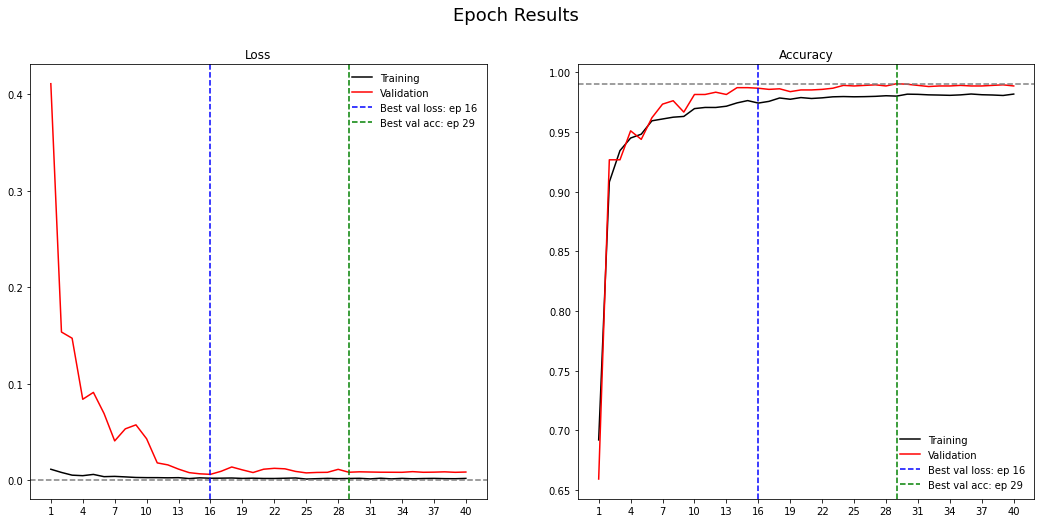

In [ ]:
fig = plt.figure(figsize = (18, 8))
fig.suptitle('Epoch Results', fontsize = 18)

abscissa = np.arange(1, CFG.N_EPOCHS + 1, 1)

# x_ticks according to CFG.N_EPOCHS for better visuailzation
if CFG.N_EPOCHS <= 20:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, 1)
else:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, int(CFG.N_EPOCHS/20) + 1)

# Loss plot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(abscissa, train_loss_history, label='Training', color = 'black')
ax1.plot(abscissa, valid_loss_history, label='Validation', color = 'red')
plt.xticks(x_ticks)
plt.axhline(0, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title("Loss")
ax1.legend(frameon=False);

# Accuracy plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(abscissa, train_acc_history, label='Training', color = 'black')
ax2.plot(abscissa, valid_acc_history, label='Validation', color = 'red')
plt.xticks(x_ticks)
plt.axhline(0.99, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title("Accuracy")
ax2.legend(frameon=False);

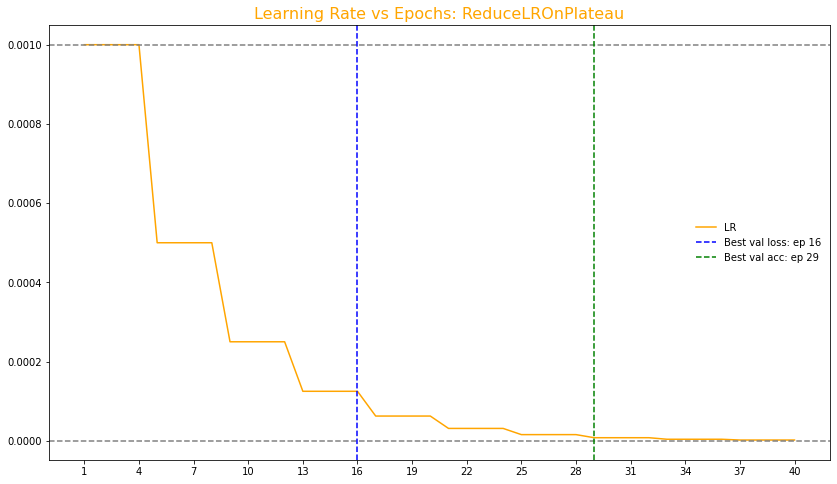

In [ ]:
fig = plt.figure(figsize = (14, 8))

abscissa = np.arange(1, CFG.N_EPOCHS + 1, 1)

# x_ticks according to CFG.N_EPOCHS for better visuailzation
if CFG.N_EPOCHS <= 20:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, 1)
else:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, int(CFG.N_EPOCHS/20) + 1)

# LR plot
plt.plot(abscissa, LR_history, label='LR', color = 'orange')
plt.xticks(x_ticks)
plt.axhline(CFG.LEARNING_RATE, linestyle = 'dashed', color = 'grey')
plt.axhline(0, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title(f"Learning Rate vs Epochs: {CFG.scheduler}", fontsize = 16, color = 'orange')
plt.legend(frameon=False);

# Inference

In [ ]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

def inference(test_loader, model):
    model.eval()

    predictions = []

    size = len(test_loader.dataset)
    num_batches = len(test_loader)

    model = DigitModel().to(device)

    if CFG.save_best_loss: # load model with best validation loss
      model.load_state_dict(torch.load(OUTPUT_PATH + f"DigitModel_ep{best_epoch_loss}.pth"))
    else: # load model with best validation accuracy
      model.load_state_dict(torch.load(OUTPUT_PATH + f"DigitModel_ep{best_epoch_acc}.pth"))

    # disable gradients for inference
    with torch.no_grad():
      for batch, X in enumerate(test_loader):

        ################################# inference #################################
        start = time.time()
        current = batch * len(X)

        X = X.to(device)

        # compute predictions
        pred = model(X)
        # softmax
        y_pred = softmax(pred.detach().cpu().numpy()) # convert tensor to numpy and apply softmax
        y_pred = np.argmax(y_pred, axis = 1) # take the indice of the max value (higher probability: predicted class)

        # store results
        predictions.append(y_pred)

        # log
        end = time.time()
        time_delta = np.round(end - start, 5)

        # if batch % (CFG.print_freq) == 0:
        #   print(f"Inference Batch: {current:>5d}/{size:>5d}: Elapsed Time: {time_delta} s")

    test_predictions = np.concatenate(predictions, axis = 0) # join sequence of arrays along axis 0
    return test_predictions

In [ ]:
# instantiate Inference Dataset class (create inference Dataset)
inference_dataset = DigitInferenceDataset(test, augmentations=None)

# create Inference DataLoader object from Dataset class object
inference_dataloader = DataLoader(inference_dataset,
                                  batch_size = CFG.BATCH_SIZE,
                                  shuffle = False)

In [ ]:
%%time
# run inference
predictions = inference(inference_dataloader, model)
predictions

CPU times: user 2.57 s, sys: 125 ms, total: 2.7 s
Wall time: 2.7 s


array([2, 0, 9, ..., 3, 9, 2])

# Submission

In [ ]:
submission = pd.read_csv(INPUT_PATH + "sample_submission.csv")
submission["Label"] = predictions

submission.to_csv(OUTPUT_PATH + 'submission.csv', index = False)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


# Check predictions

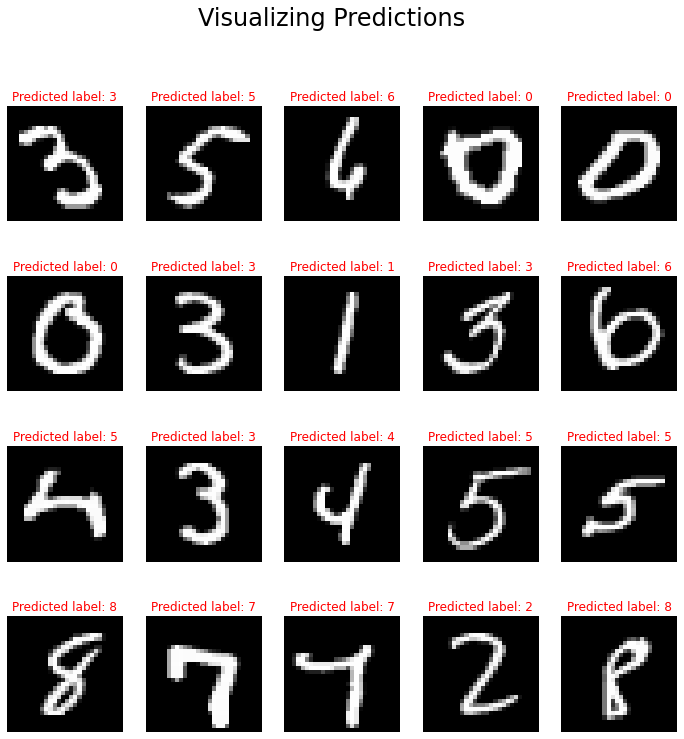

In [ ]:
# check some predictions

fig = plt.figure(figsize = (12, 12))
fig.suptitle('Visualizing Predictions', fontsize = 24)

# define a range of predictions to plot
begin = 130
end = begin + 20

for i in range(begin, end):

  img = np.array(test.iloc[i, :]).reshape(1, 1, 28, 28) # reshape to image dimensions
  plt.subplot(4, 5, i + 1 - begin) # 4 rows and 5 columns plot
  label = str(submission.loc[i, 'Label'])
  plt.title("Predicted label: " + label, color="red") # write label in each image title
  plt.imshow(np.squeeze(img), cmap='gray') # plot image
  plt.axis('off')